# Tutorial: Generating Macronova lightcurves based on ztf_sim output 

This notebook shows how to load the output for Eric's survey simulator `ztf_sim` and generate Macronova lightcurves for it using an SED from Rosswog et al. (2016). (Check out the other notebooks for examples how to simulate other transients.)

*Note:* You need to download Eric's newest sample output [here](ftp://ftp.astro.caltech.edu/users/ebellm/one_year_sim_incomplete.db). The link was also included in Eric's email, so you will likely only need to change the path below.

Furthermore you'll require the dust map from Schlegel, Finkbeiner & Davis (1998) for full functionality. It can be found [here](https://github.com/kbarbary/sfddata/archive/master.tar.gz).

In [1]:
import os
home_dir = os.environ.get('HOME')

# Please enter the filename of the ztf_sim output file you would like to use. The example first determines
# your home directory and then uses a relative path (useful if working on several machines with different usernames)
survey_file = os.path.join(home_dir, 'data/ZTF/one_year_sim_incomplete.db')

# Please enter the path to where you have placed the Schlegel, Finkbeiner & Davis (1998) dust map files
# You can also set the environment variable SFD_DIR to this path (in that case the variable below should be None)
sfd98_dir = os.path.join(home_dir, 'data/sfd98')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import simsurvey
import sncosmo
from astropy.cosmology import Planck15

In [3]:
# Load the CCD corners from file
ccd_corners = np.genfromtxt('data/ZTF_corners.txt')
ccds = [ccd_corners[4*k+16:4*k+20] for k in range(16)]

In [4]:
bands = { 
  'ztfr' : 'data/ztfr_eff.txt',
  'ztfg' : 'data/ztfg_eff.txt',
  }

for bandname in bands.keys() :
    fname = bands[bandname]
    b = np.loadtxt(fname)
    band = sncosmo.Bandpass(b[:,0], b[:,1], name=bandname)
    sncosmo.registry.register(band)

In [5]:
# Load simulated survey from file (download from ftp://ftp.astro.caltech.edu/users/ebellm/one_year_sim_incomplete.db)
# Currently DES filters are used as proxies for ZTF filters
plan = simsurvey.SurveyPlan(load_opsim=survey_file, band_dict={'g': 'ztfg', 'r': 'ztfr'}, ccds=ccds)

mjd_range = (plan.cadence['time'].min(), plan.cadence['time'].max())

In [6]:
# To review the pointing schedule, you can use this table
plan.cadence

time,band,skynoise,RA,Dec,field
float64,str4,float64,float64,float64,int64
57391.1532438,ztfr,466.328956285,40.25,24.83077,611
57391.1537067,ztfr,466.328956285,40.25,24.83077,611
57391.1541697,ztfr,466.328956285,40.25,24.83077,611
57391.1546835,ztfr,466.147740547,42.04348,31.75385,659
57391.1551464,ztfr,466.147740547,42.04348,31.75385,659
57391.155704,ztfr,467.844452779,47.75,24.83077,612
57391.1561669,ztfr,467.844452779,47.75,24.83077,612
57391.1567046,ztfr,472.272919804,55.25,24.83077,613
57391.1571676,ztfr,472.272919804,55.25,24.83077,613


## Transient Model
In this example the transient model is create from an ASCII file. Alternatively you could use the built-in SN models of sncosmo or the Blackbody model provided in simsurvey.

In [7]:
# Load phase, wavelengths and flux from file
phase, wave, flux = sncosmo.read_griddata_ascii('data/macronova_sed_wind20.dat')

# Create a time series source
source = sncosmo.TimeSeriesSource(phase, wave, flux)

# Create the model that combines SED and propagation effects
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source=source,
                      effects=[dust],
                      effect_names=['host'],
                      effect_frames=['rest'])

## Transient dostribution
You need to define a function that draws the model parameters (except z and t0) from a random distribution.
In this case only host exinction is random but in addition the amplitude of each MN must be scaled for its luminosity distance.

In [8]:
def random_parameters(redshifts, model,
                      r_v=2., ebv_rate=0.11,
                      **kwargs):
    cosmo = Planck15
    
    # Amplitude
    amp = []
    for z in redshifts:
        d_l = cosmo.luminosity_distance(z).value * 1e5
        amp.append(d_l**-2)

    return {
        'amplitude': np.array(amp),
        'hostr_v': r_v * np.ones(len(redshifts)),
        'hostebv': np.random.exponential(ebv_rate, len(redshifts))
    }

## TransientGenerator
The transient generator combines model and ditribution, and randomly draws all parameters needed to simulate the lightcurves.

(Note that here we also set the volumetric rate as funtion of z. For macronovae, a good guess would be $3\cdot 10^{-7}~\textrm{Mpc}^{-3}~\textrm{yr}^{-1}$ but this would only results in a couple of observed macronovae. For this example we'll use a 100 times larger rate.)

In [9]:
transientprop = dict(lcmodel=model,
                    lcsimul_func=random_parameters)

mjd_range = (plan.cadence['time'].min(), plan.cadence['time'].max())

tr = simsurvey.get_transient_generator([0.0, 0.05], ratekind='custom',
                                       ratefunc=lambda z: 3e-5,
                                       dec_range=[-30,90],
                                       mjd_range=[mjd_range[0] - 20,
                                                  mjd_range[1]],
                                       transientprop=transientprop,
                                       sfd98_dir=sfd98_dir)

## SimulSurvey
Lastly, all parts are combined in a SimulSurvey object that will generate the lightcurves.
(This may take about a minute or two.)

In [10]:
instprop = {"ztfg":{"gain":1.,"zp":30,"zpsys":'ab'},
            "ztfr":{"gain":1.,"zp":30,"zpsys":'ab'}}

survey = simsurvey.SimulSurvey(generator=tr, plan=plan, instprop=instprop)
    
lcs = survey.get_lightcurves(
    progress_bar=True, notebook=True # If you get an error because of the progress_bar, delete this line.
)

Determining field IDs for all objects

Generating lightcurves



In [11]:
lcs[0]

time,band,flux,fluxerr,zp,zpsys,field,ccd
float64,str4,float64,float64,int64,str2,int64,int64
57404.2026094,ztfg,773.192276063,599.395831978,30,ab,463,1
57404.2030724,ztfg,279.871426341,599.395831978,30,ab,463,1
57404.2671931,ztfg,-89.735766561,640.536255915,30,ab,463,1
57404.2676561,ztfg,-644.990233027,640.536255915,30,ab,463,1
57405.2298978,ztfr,-597.472896858,1093.75808999,30,ab,463,1
57420.1253733,ztfg,457.306996434,342.972739757,30,ab,463,1
57420.1258362,ztfg,491.381462313,342.972558356,30,ab,463,1
57420.1262992,ztfg,344.77648067,342.972376932,30,ab,463,1
57420.1991555,ztfg,112.227031591,346.353863015,30,ab,463,1


In [12]:
lc = lcs[0]

In [13]:
lc.as_array()

array([ (57404.2026094, 'ztfg', 773.1922760628713, 599.3958319776059, 30, 'ab', 463, 1),
       (57404.2030724, 'ztfg', 279.8714263414967, 599.3958319776059, 30, 'ab', 463, 1),
       (57404.2671931, 'ztfg', -89.73576656098524, 640.5362559152752, 30, 'ab', 463, 1),
       (57404.2676561, 'ztfg', -644.9902330266219, 640.5362559152752, 30, 'ab', 463, 1),
       (57405.2298978, 'ztfr', -597.4728968577053, 1093.7580899882507, 30, 'ab', 463, 1),
       (57420.1253733, 'ztfg', 457.3069964337284, 342.9727397566996, 30, 'ab', 463, 1),
       (57420.1258362, 'ztfg', 491.3814623131709, 342.9725583555997, 30, 'ab', 463, 1),
       (57420.1262992, 'ztfg', 344.7764806702129, 342.9723769319949, 30, 'ab', 463, 1),
       (57420.1991555, 'ztfg', 112.22703159127587, 346.35386301534106, 30, 'ab', 463, 1),
       (57420.1996185, 'ztfg', 696.9222816248105, 346.3536863435198, 30, 'ab', 463, 1),
       (57420.2000814, 'ztfg', 212.44023779280366, 346.3535097307927, 30, 'ab', 463, 1),
       (57420.2005444, '

## Analysing the output

The output of `get_lightcurves()` is a `LightcurveCollection` object. Below are some examples how to assess survey statistics based on this.

The first skyplot shows all macronovae that were active when a field was observed (but they may have been too faint to be detected). The second skyplot shows the macronovae that had at least one observation with S/N > 5. 

/home/ufeindt/.local/lib/python2.7/site-packages/simsurvey-0.3.0-py2.7.egg/simsurvey/simultarget.py:336: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/ufeindt/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


MNe pointed to: 330 out of 517


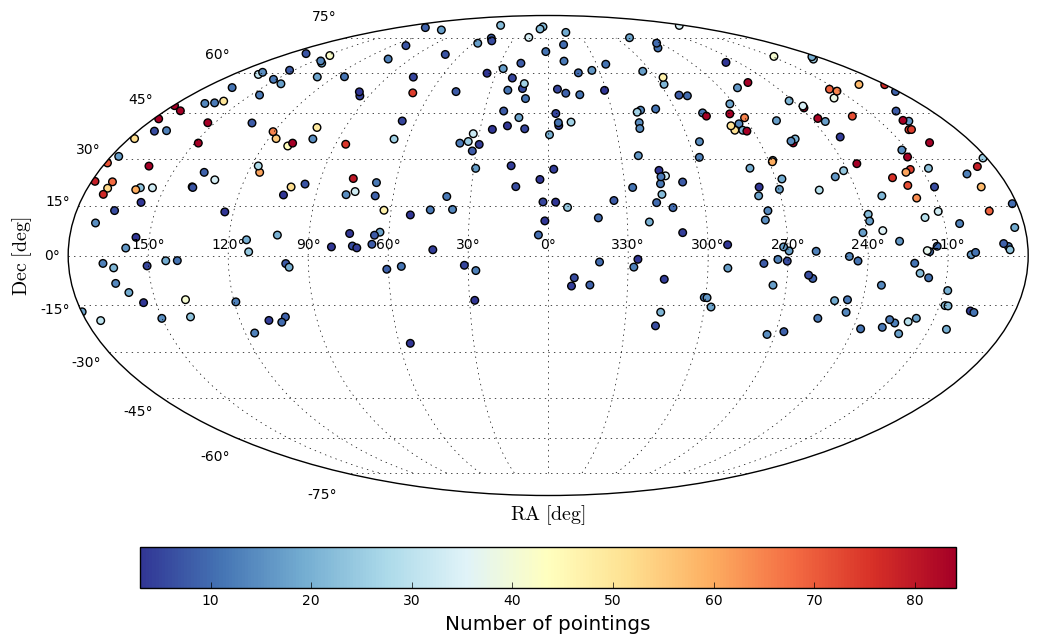

In [14]:
idx = lcs.meta['idx_orig']
n_obs = np.zeros(survey.generator.ntransient)
n_obs[idx] = np.array([len(a) for a in lcs])

survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of pointings", mask=idx)
print 'MNe pointed to: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

MNe detected: 42 out of 517


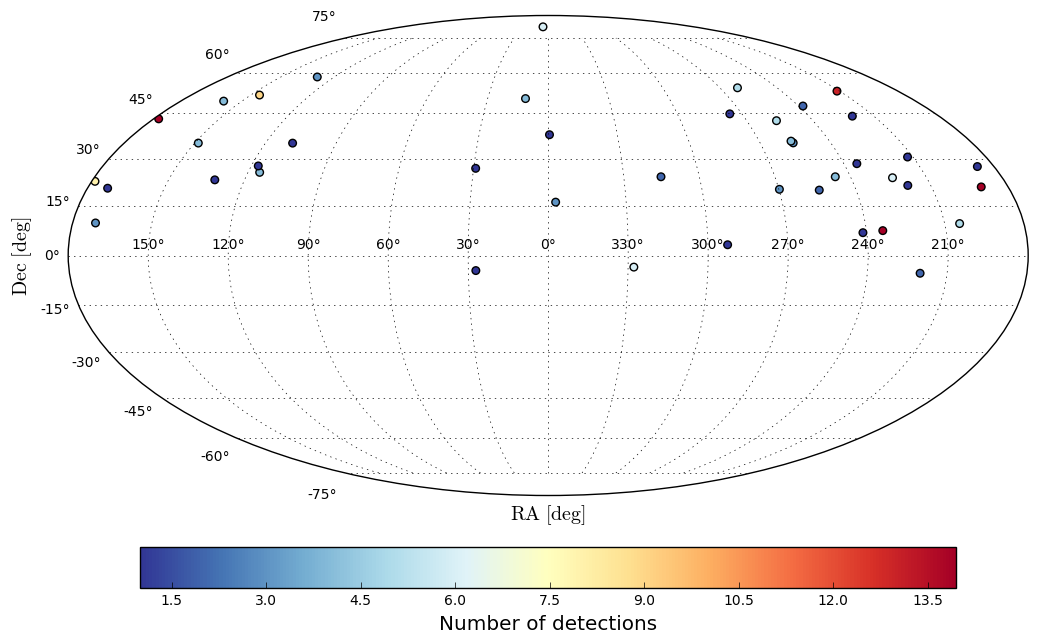

In [15]:
lcs_det = [lc[lc['flux']/lc['fluxerr'] > 5] for lc in lcs]

idx_det = lcs.meta['idx_orig'][np.array([len(lc) > 0 for lc in lcs_det])]
n_det = np.zeros(survey.generator.ntransient)
lcs_det = [lc for lc in lcs_det if len(lc) > 0]
n_det[idx_det] = np.array([len(lc) for lc in lcs_det])

survey.generator.show_skycoverage(cscale=n_det, cblabel="Number of detections", mask=idx_det)
print 'MNe detected: %i out of %i'%(np.sum(n_det > 0), survey.generator.ntransient)

You can inspect the lightcurves manually. This example should return the lightcurve with the most points with S/N > 5.

In [16]:
k = np.where(lcs.meta['idx_orig'] == np.where(n_det == n_det.max())[0][0])[0][0]
lcs[k]

time,band,flux,fluxerr,zp,zpsys,field,ccd
float64,str4,float64,float64,int64,str2,int64,int64
57393.3818342,ztfg,1478.44048756,636.987514014,30,ab,582,8
57393.3822971,ztfg,-563.863396973,636.987514014,30,ab,582,8
57393.4285195,ztfr,-816.132068358,671.350529499,30,ab,582,8
57393.4289825,ztfr,996.246812268,671.350529499,30,ab,582,8
57393.4357921,ztfg,924.349489791,394.815210682,30,ab,582,8
57393.4362551,ztfg,-177.108214157,394.815210682,30,ab,582,8
57393.4646977,ztfr,398.823059586,539.787261558,30,ab,582,8
57393.4651607,ztfr,537.893452885,539.787261558,30,ab,582,8
57397.3809358,ztfg,840.024004787,604.804332643,30,ab,582,8


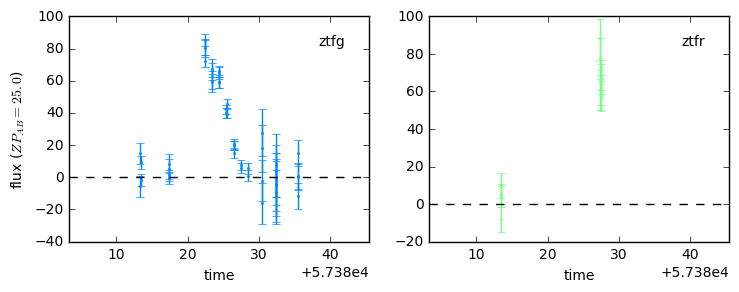

In [17]:
_ = sncosmo.plot_lc(lcs[k])

The two last figures show how early the MNe are detected and at what redshifts.

SNe found before peak: 0


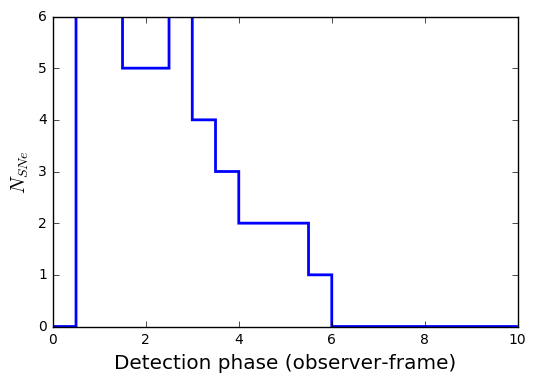

In [18]:
z = np.array([lc.meta['z'] for lc in lcs_det])
p_i = np.array([lc['time'].min() - lc.meta['t0'] for lc in lcs_det])
p_e = np.array([lc['time'].max() - lc.meta['t0'] for lc in lcs_det])

plt.hist(p_i, lw=2, histtype='step', range=(0,10), bins=20)
print 'SNe found before peak:', np.sum(p_i < 0)
plt.xlabel('Detection phase (observer-frame)', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')

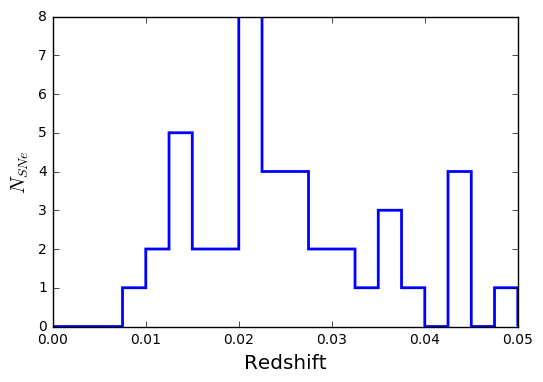

In [19]:
n = np.array([len(lc) for lc in lcs_det])
snr_max = np.array([max(lc['flux']/lc['fluxerr']) for lc in lcs_det])
plt.hist(z, lw=2, histtype='step', range=(0,0.05),bins=20)
plt.xlabel('Redshift', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')
_ = plt.xlim((0, 0.05))